In [6]:
def compare_results(x, y):
    a = x.values
    b = y.values

    # wilcoxon test
    pwil = wilcoxon(a, b).pvalue
    
    # binomial test
    x_wins = np.mean(a > b)
    y_wins = np.mean(b > a)
    draw = np.mean(a == b)
    pbin = binom_test(np.sum(x_wins), n=x.shape[0], p=0.5, alternative='two-sided')
    diff = x - y
    
    # combine results
    results = pd.Series({'wilcoxon_pval': pwil,
                        'x_wins': x_wins, 
                        'y_wins': y_wins, 
                        'draw': draw,
                        'binomial_pval': pbin})
    results = pd.concat([results, diff.describe()], axis=0)
    # display results
    display(pd.DataFrame(results).T.drop(columns='count').round(3))
    
    # scatter plot
    fig, ax = plt.subplots(1)
    ax.scatter(a, b)
    ax.plot([0, np.max([np.max(x), np.max(y)])], 
            [0, np.max([np.max(x), np.max(y)])], 
            'red', linewidth=1)
    # ax.set_aspect('equal')
    ax.set(xlabel=x.name, ylabel=y.name);

In [7]:
with open('../sktime/pigs.txt', 'r') as f:
    datasets = [line.strip('\n') for line in f.readlines()]
len(datasets)

78

## Evaluating different parameter settings
* results were not obtained from tuning on a validation set (i.e. part of the training set), but instead from training classifier with parameter combination on whole train set and evaluating it on the test set

In [8]:
n_estimators_list = [3, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700]
features_list = [
                 ['m', 'std', 'slp'],
                 ['m', 'std', 'slp', 'sk'],
                 ['m', 'std', 'slp', 'sk', 'k'],
                 ['m', 'std', 'slp', 'k']
             ]
n_intervals_list = [1, 2, 3, 5, 10, 20, 'sqrt', 'log']
params = [f"{i}_{'_'.join(j)}_{k}" 
          for i, j, k in product(n_estimators_list, features_list, n_intervals_list)]
len(params)

384

In [9]:
files = glob.glob('tsf_*params.txt')
print(len(files))

results = np.stack([np.loadtxt(f) for f in files])
results.shape

78


(78, 384, 3)

In [10]:
acc = pd.DataFrame(results[:, :, 2], index=datasets, columns=params) # accuracy
time = pd.DataFrame(results[:, :, 0] + results[:, :, 1], index=datasets, columns=params)
acc.to_csv('tsf_accuracy_params.csv')
time.to_csv('tsf_time_params.csv')
acc.head()

,3_m_std_slp_1,3_m_std_slp_2,3_m_std_slp_3,3_m_std_slp_5,3_m_std_slp_10,3_m_std_slp_20,3_m_std_slp_sqrt,3_m_std_slp_log,3_m_std_slp_sk_1,3_m_std_slp_sk_2,...,700_m_std_slp_sk_k_sqrt,700_m_std_slp_sk_k_log,700_m_std_slp_k_1,700_m_std_slp_k_2,700_m_std_slp_k_3,700_m_std_slp_k_5,700_m_std_slp_k_10,700_m_std_slp_k_20,700_m_std_slp_k_sqrt,700_m_std_slp_k_log
ECGFiveDays,0.721311,0.704918,0.754098,0.836066,0.786885,0.737705,0.786885,0.655738,0.688525,0.704918,...,0.737705,0.770492,0.770492,0.770492,0.754098,0.754098,0.770492,0.721311,0.754098,0.770492
MoteStrain,0.692029,0.681159,0.677536,0.717391,0.684783,0.753623,0.750000,0.757246,0.713768,0.652174,...,0.789855,0.789855,0.742754,0.760870,0.764493,0.786232,0.786232,0.775362,0.778986,0.775362
BirdChicken,0.428250,0.756000,0.819500,0.873000,0.874000,0.922250,0.896000,0.739000,0.492750,0.733000,...,0.989750,0.990500,0.952750,0.982500,0.988250,0.991250,0.992500,0.989500,0.990750,0.989250
Coffee,0.775610,0.809756,0.770732,0.804878,0.829268,0.814634,0.790244,0.795122,0.760976,0.834146,...,0.848780,0.848780,0.848780,0.848780,0.848780,0.853659,0.858537,0.839024,0.848780,0.848780
BeetleFly,0.586527,0.823461,0.707317,0.757259,0.926829,0.853659,0.973287,0.907085,0.756098,0.718931,...,0.974448,0.944251,0.843206,0.893148,0.916376,0.957027,0.972125,0.980256,0.975610,0.945412


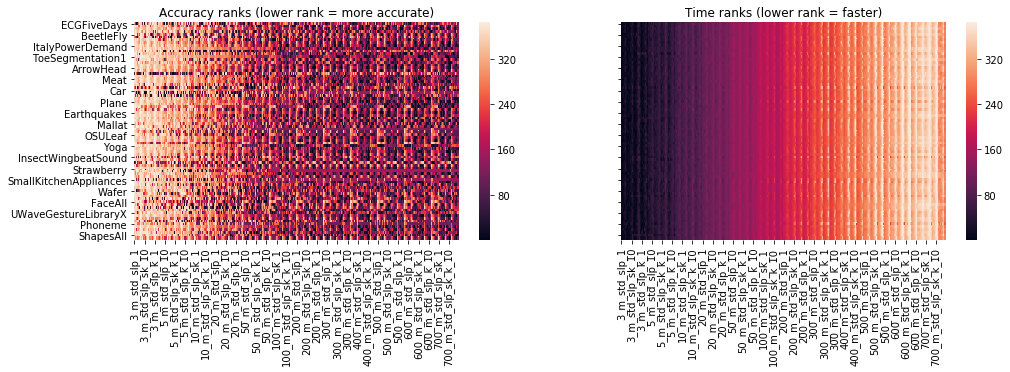

In [11]:
# rank heatmap
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=plt.figaspect(.25), sharey=True)
sns.heatmap(acc.rank(axis=1, ascending=False), ax=ax0)
ax0.set(title='Accuracy ranks (lower rank = more accurate)')
sns.heatmap(time.rank(axis=1), ax=ax1)
ax1.set(title='Time ranks (lower rank = faster)');

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.0,0.231,0.641,0.128,0.0,-0.015,0.03,-0.141,-0.028,-0.007,0.0,0.04


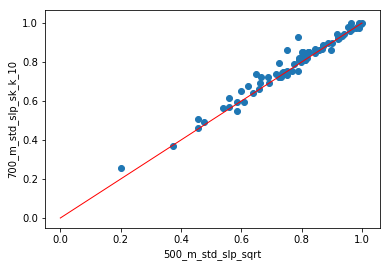

In [12]:
# default vs config with best avg rank
default = '500_m_std_slp_sqrt'
default_acc = acc.loc[:, default]

avg_rank = acc.rank(axis=1, ascending=False).mean(axis=0).sort_values(ascending=True)
best_avg_rank_acc = acc.loc[:, avg_rank.index[0]]
compare_results(default_acc, best_avg_rank_acc)

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.0,0.0,0.987,0.013,0.0,-0.048,0.041,-0.167,-0.07,-0.034,-0.016,0.0


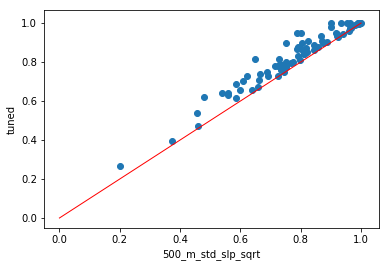

In [13]:
# default vs tuned
tuned_acc = acc.max(axis=1)
tuned_acc.name = 'tuned'
compare_results(default_acc, tuned_acc)

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.0,0.0,0.949,0.051,0.0,-0.032,0.033,-0.167,-0.048,-0.02,-0.009,0.0


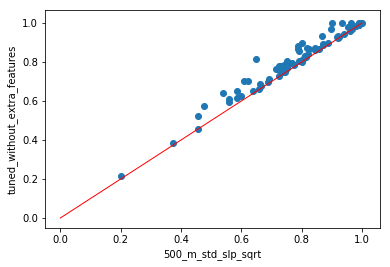

In [14]:
# tuned without extra features
acc_noextra = acc.drop(columns=acc.filter(regex='sk|k'))
assert acc_noextra.shape[1] == len(n_estimators_list) * len(n_intervals_list)

# default vs tuned without extra features
tuned_acc_noextra = acc_noextra.max(axis=1)
tuned_acc_noextra.name = 'tuned_without_extra_features'
compare_results(default_acc, tuned_acc_noextra)

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.0,0.0,0.705,0.295,0.0,-0.016,0.021,-0.092,-0.02,-0.01,0.0,0.0


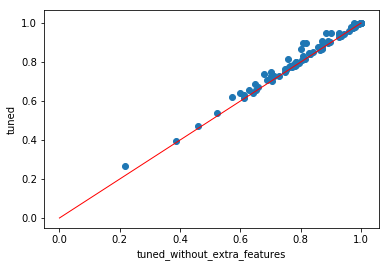

In [15]:
compare_results(tuned_acc_noextra, tuned_acc)

In [16]:
# finding a better default setting: faster and more accurate in terms of average rank?
time_rank = time.rank(axis=1).mean(axis=0)

acc_rank = acc.rank(axis=1, ascending=False).mean(axis=0)

more_acc = acc_rank <= acc_rank.loc[default]
faster = time_rank <= time_rank.loc[default]
acc_rank[more_acc & faster].sort_values().head(5)

400_m_std_slp_sk_k_10     91.743590
300_m_std_slp_sk_k_10     92.653846
700_m_std_slp_k_10        96.544872
200_m_std_slp_sk_k_10     97.083333
400_m_std_slp_sk_k_log    97.128205
dtype: float64

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.0,0.231,0.577,0.192,0.0,-0.013,0.032,-0.145,-0.026,-0.007,0.0,0.1


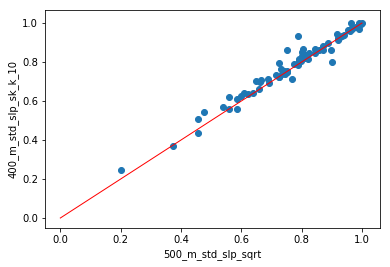

In [17]:
faster_and_more_acc = acc.loc[:, '400_m_std_slp_sk_k_10']
compare_results(default_acc, faster_and_more_acc)

## Evaluating performance with extra features
* tuned on train set using 5 or 10 fold cross-validation, evaluated on test set

In [18]:
results = np.loadtxt('tsf_tuned_features.txt')
acc_tuned_features = pd.Series(results[:, 2], index=datasets, name='acc_tuned_features')
time_tuned_featurs = np.sum(results[:, :2])

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.756,0.513,0.487,0.0,0.0,-0.011,0.236,-0.664,-0.155,0.006,0.1,0.758


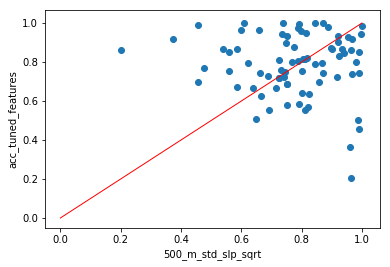

In [20]:
compare_results(default_acc, acc_tuned_features)

## Tuning with out-of-bag score
* finding best parameter combination based on the oob score, then refitting on whole training set with best parameter setting, then evaluating on test set

In [55]:
oob_tuned = np.loadtxt('tsf_oob_tuned.txt')
oob_tuned.shape

(78, 4)

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.79,0.5,0.5,0.0,0.0,-0.011,0.232,-0.637,-0.16,0.004,0.113,0.718


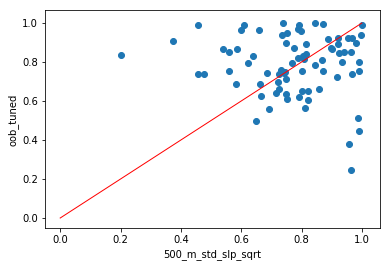

In [68]:
oob_time = np.sum(oob_tuned[:, :3], axis=1)
oob_acc = pd.Series(oob_tuned[:, 3], name='oob_tuned', index=datasets)
compare_results(default_acc, oob_acc)

## Full tuning over space of feature, number of estimators and number of interval

In [21]:
full_tuned = np.loadtxt('tsf_tuned_full.txt')
full_tuned.shape

(78, 3)

,wilcoxon_pval,x_wins,y_wins,draw,binomial_pval,mean,std,min,25%,50%,75%,max
0,0.0,0.782,0.218,0.0,0.0,0.328,0.354,-0.497,0.055,0.415,0.622,0.945


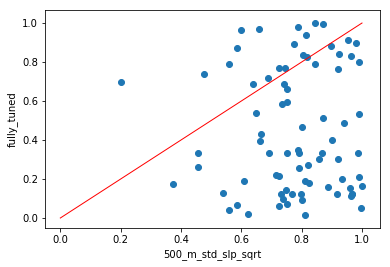

In [25]:
tuned_time = np.sum(full_tuned[:, :2], axis=1)
tuned_acc = pd.Series(full_tuned[:, 2], name='fully_tuned', index=datasets)
compare_results(default_acc, tuned_acc)